In [35]:
#import modules
import matplotlib.pyplot as plt, numpy as np
from datetime import datetime
import GUI

In [36]:
#constants:

HOME = 'G28'        #this is a custom saved location
positioning = 'G90' #absolute positioning
units = 'G21'       #everything using mm

#settings:
material = 'PCL'    #purely informational, does not affect printer function
printer = 'Voron'   #purely informational
nozzle_temp = 230   #C probably depends on material...
bed_temp = 35       #C sometimes will get stuck if above 40

#platform limits(be aware that it could go over if inaccurate)
x_max = 120     #mm
y_max = 120     #mm

#Line Settings: How wide and tall for the box of lines: in mm
product_width = 50  #mm SHOULD NOT BE GREATER THAN X_MAX
product_height = 50 #mm SHOULD NOT BE GREATER THAN Y_MAX
num_groups = 4     #number of line groups - consecutive lines made with same speed
line_per_group = 3  #mm gap between lines of the same line group
ratio_of_dxgroup_dxline = 2 #ratio between distance between lines and distance between groups of lines so dxg/dxl

#for incrementing pts only:
pts_per_line = 5    #mm Choose 1mm if you want each whole line representing one speed.

#testing all feeding speeds within range:
nozzle_v_min = 1      #mm/min
nozzle_v_max = 8       #mm/min

velocity_of_nozzle = 400    #mm^2/min
bed_dist = 0.5  #mm

In [37]:
#trigger GUI
try:
    product_width, product_height, num_groups, line_per_group, pts_per_line, nozzle_v_min, nozzle_v_max, velocity_of_nozzle  = GUI.run_GUI()
except ValueError:
    print("Input Invalid: Settings not Saved")


Not Using Collagen!
Entered number: 2.0
Entered number: 7.0
Entered number: 1.0
Entered number: 8.0
Entered number: 10.0
Entered number: 0.5
Entered number: 0.5
Entered number: 200.0
[2.0, 7.0, 1.0, 8.0, 10.0, 0.5, 0.5, 200.0]
Uploading!


In [38]:
#Calculations:
dx_line = product_width/(num_groups*(line_per_group-1)+ratio_of_dxgroup_dxline*(num_groups-1))
print(dx_line)
dx_group = dx_line*ratio_of_dxgroup_dxline
print(dx_group)
nozzle_dv = (nozzle_v_max-nozzle_v_min)/num_groups   #mm/s

0.2857142857142857
0.5714285714285714


In [39]:
#Coordinate plotting:
input_coordinate = []

#Get beginning location: gotta find it

#use for nxn product
def get_coordinate_init_centered():
    #always want the product to be centered, cannot go beyond the limit
    coord_init = np.array([x_max-product_width,y_max-product_height])/2
    return coord_init
    
#use for all else
def get_coordinate_init_cornered():
    #will just be lower left corner
    return [10,10]

if(product_width == product_height):coord_init = get_coordinate_init_centered()
else: coord_init = get_coordinate_init_cornered()

#generate rough lines, then can populate new coordinate list with linspaced points for increments

def find_next_pt(input, viable_opt):
    if(input == viable_opt[0]):
        return viable_opt[1]
    return viable_opt[0]

#generating lines w/out increment:
input_coordinate.append(coord_init)
for group in range(int(num_groups)):
    options = [coord_init[1], coord_init[1]+product_height]
    for line in range(int(line_per_group)):
        
        current_x = (input_coordinate[-1])[0]
        current_y = (input_coordinate[-1])[1]
        next_pt = [current_x,find_next_pt(current_y,options)]
        input_coordinate.append(next_pt)
        
        if line != line_per_group-1:
            current_x = (input_coordinate[-1])[0]
            current_y = (input_coordinate[-1])[1]
            next_pt = [current_x+dx_line, current_y]
            input_coordinate.append(next_pt)
        
    current_x = (input_coordinate[-1])[0]
    current_y = (input_coordinate[-1])[1]
    if group != num_groups-1:
        input_coordinate.append([current_x+dx_group,current_y])

input_coordinate = np.array(input_coordinate)
print(input_coordinate)
print(len(input_coordinate))

[[10.         10.        ]
 [10.         17.        ]
 [10.28571429 17.        ]
 [10.28571429 10.        ]
 [10.57142857 10.        ]
 [10.57142857 17.        ]
 [10.85714286 17.        ]
 [10.85714286 10.        ]
 [11.14285714 10.        ]
 [11.14285714 17.        ]
 [11.42857143 17.        ]
 [11.42857143 10.        ]
 [11.71428571 10.        ]
 [11.71428571 17.        ]
 [12.         17.        ]
 [12.         10.        ]]
16


Text(0.5, 1.0, 'vector form')

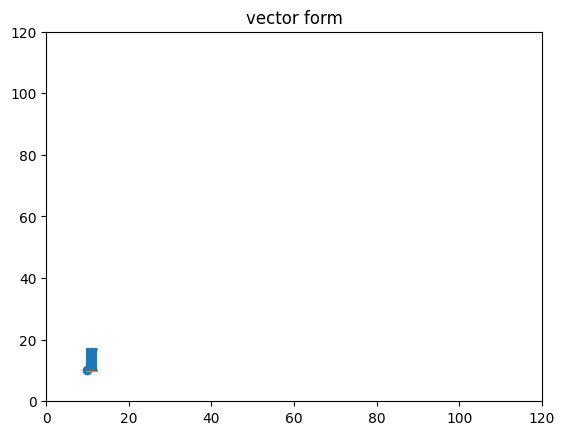

In [40]:
#graph points
plt.scatter(input_coordinate[0][0],input_coordinate[0][1])
x = input_coordinate[:,0]
y = input_coordinate[:,1]
plt.xlim(0,120)
plt.ylim(0,120)
plt.plot(x,y)
plt.scatter(x,y, s=2)
plt.title("vector form")

In [41]:
#incrementize coordinates:
spliced_coordinate = np.array([coord_init])

def splice_vector_into_pts(xy_init, xy_final, pts_per_line):
    result = np.linspace(xy_init,xy_final,pts_per_line)
    return result

for set in range(len(input_coordinate)-1):
    spliced_vector = splice_vector_into_pts(input_coordinate[set],input_coordinate[set+1],int(pts_per_line))
    spliced_coordinate = np.concatenate((spliced_coordinate,spliced_vector),axis=0)

spliced_coordinate = np.delete(spliced_coordinate,0,0)

#print(spliced_coordinate)
print(f"Pts: {len(spliced_coordinate)}")

Pts: 150


Text(0.5, 1.0, 'spliced')

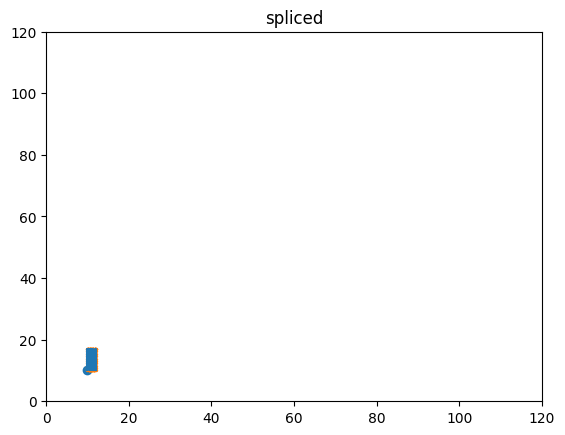

In [42]:
#graph points of splice (should look the same as previous graph)
plt.scatter(spliced_coordinate[0][0],spliced_coordinate[0][1])
x = spliced_coordinate[:,0]
y = spliced_coordinate[:,1]
plt.xlim(0,120)
plt.ylim(0,120)
plt.plot(x,y)
plt.scatter(x,y, s=2)
plt.title("spliced")

In [43]:
#create array for each point's speed
speed_corresponding_to_spliced_coord = np.linspace(nozzle_v_min,nozzle_v_max,len(spliced_coordinate))
#print(speed_corresponding_to_spliced_coord)
print(len(speed_corresponding_to_spliced_coord))

150


In [44]:
#gcode writer that will combine coordinate information and speed information
def get_gcode_block(position, fillament_speed):
    return f"G1 X{position[0]} Y{position[1]} Z{bed_dist} E{fillament_speed}"

def get_gcode_block_movement_only(position):
     return f"G1 X{position[0]} Y{position[1]} Z{bed_dist}"

In [45]:
#create file:
file_name = input("Enter file name: ")
#path = pathlib.Path().resolve()

with open(str(file_name) + ".gcode", "w") as f:
    #description
    f.write(";File Name: " + str(file_name))
    f.write("\n;Time Generated: " + str(datetime.today().strftime('%Y-%m-%d %H:%M:%S')))  #get date
    f.write("\n;Printer Type: " + str(printer))
    f.write("\n;dimension of product: " + str(product_width) +"x"+ str(product_height) +" mm")
    f.write("\n;details of product: " + str(num_groups) +" groups of "+ str(line_per_group) +" lines each")
    f.write("\n;speed increment: " + str(nozzle_v_min) +" to "+ str(nozzle_v_max) +" mm/min for " +str(len(speed_corresponding_to_spliced_coord)) +" pts total")
    #set up
    f.write("\n\n\n" + str(positioning))
    f.write("\n" + str(units))
    f.write(f"\nM83")
    f.write(f"\nG28 F{velocity_of_nozzle} Z{bed_dist}")
    

    #nozzle stuff:
    f.write(f"\nSET_HEATER_TEMPERATURE HEATER=extruder TARGET={nozzle_temp}\nTEMPERATURE_WAIT SENSOR=extruder MINIMUM={nozzle_temp} MAXIMUM={nozzle_temp+10}\n")
    f.write(f"M190 S{bed_temp}\n\n")
    for i in range(len(spliced_coordinate)):
            line = get_gcode_block(spliced_coordinate[i],speed_corresponding_to_spliced_coord[i])
            f.write("\n" + line)
    
    #ending code here
    #f.write("\n\n\nM104 T0 S0\nM140 S0\nM84")
    f.write("\nM30\n;end of code")
